- [1. Importing Packages and Dataset](#1)
- [2. Data Wrangling and Preprocessing for Modeling](#2)
- [3. Modeling](#3)
    - [3.1 Random Forest Classifier with Ridge as Feature Selector](#3_1)
    - [3.2 Logistic Regression with Lasso to Select Features](#3_2)

### Temporary Conclusion Thus Far:
Features to Include in Future Learning:
- Winrate in past 10 games
- Consecutive games won and consecutive games lost
- Number of all stars and age of all stars
- Cumulative seasonal stats
- Current rankings of certain stats in the season
- **Win rate at home and away**!!

Questions Thus Far:
- Rationale behind the decision to exclude certain features in below code
    - disregard = disregard + ["home_opp_5_x","target_x","target_y", "Wins_x", "Losses_x", "Wins_opp_x", "Losses_opp_x", "season_x" , "won_x" , "home_5_x" ,"home_10_x" ,"season_5_x", "season_10_x" , "Wins_y" , "Losses_y" , "Wins_opp_y" , "Losses_opp_y" , "season_y" , "won_y" ,"home_5_y", "home_10_y","season_5_y", "season_10_y","home_opp_5_y", "home_opp_10_y"]

## 1. Import Packages and Dataset <a id='1'></a>

In [142]:
## Import desired packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import statsmodels.api as sm
import gc
import matplotlib
from tqdm import tqdm
import itertools
import pickle

from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, TimeSeriesSplit, ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.cluster import KMeans, DBSCAN

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, silhouette_score, f1_score, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression, SequentialFeatureSelector
import datetime

In [94]:
def add_target(team):
    team['target'] = team['won'].shift(-1)
    return team

def winrate(team):
    total = team['Wins'] + team['Losses']
    total_opp = team['Wins_opp'] + team['Losses_opp']
    team['winrate'] = team['Wins'] / total
    team['winrate_opp'] = team['Wins_opp'] / total_opp
    return team
    
def find_team_average_n(team, period):
    numeric_columns = team.select_dtypes(include=np.number)
    rolling = numeric_columns.rolling(period).mean()
    return rolling

def ratio_between_m_and_n(data, columns, m=5, n=10):
    for column in columns:
        col_name = column.split('_')[0]
        data[f'{col_name}_{m}_{n}'] = data[f'{col_name}_{m}'] / data[f'{col_name}_{n}']
    return data

def rolling(data):
    df_rolling_5 = data[list(valid_columns) + ['Teams','won', "season"]]
    df_rolling_5 = df_rolling_5.groupby(['Teams', 'season'], group_keys = False).apply(find_team_average_10)
    df_rolling_10 = data[list(valid_columns) + ['Teams','won', "season"]]
    df_rolling_10 = df_rolling_10.groupby(['Teams', 'season'], group_keys = False).apply(find_team_average_10)
    rolling_columns_10 = [f"{col}_10" for col in df_rolling_10.columns]
    rolling_columns_5 = [f"{col}_5" for col in df_rolling_5.columns]
    df_rolling_10.columns = rolling_columns_10
    df_rolling_5.columns = rolling_columns_5
    df = pd.concat([data, df_rolling_5, df_rolling_10], axis=1)
    return df

def rolling_no_merge(data, window_sizes=[5, 10], valid_column='won'):

    for window in window_sizes:
        # Group by 'Teams' and 'season' and then apply rolling window for each group

            new_col_name = f"{valid_column}_rolling_{window}"
            data[new_col_name] = data.groupby(['Teams', 'season'])[valid_column].transform(lambda x: x.rolling(window, min_periods=1).mean())
            
    return data

def shift_col(team, col_name):
    team = team.sort_values('date')
    next_col = team[col_name].shift(-1)
    return next_col

def add_col(df, col_name):
    return df.groupby("Teams", group_keys=False).apply(lambda x: shift_col(x, col_name))

In [95]:
path_2022 = "/Users/liqingyang/Documents/GitHub/sports_trading/sports_betting/data/NBA_2022.csv"
nba_2022 = pd.read_csv(path_2022, index_col=0)

# We want to predict the outcome of the next game based on season stats 
nba_2022[nba_2022['Teams'] == 'LAL'].sort_values('date')

,mp,fg,fga,fg%,3p,3pa,3p%,ft,fta,ft%,...,TOV%_opp,ORB%_opp,FT/FGA_opp,ORtg_opp,Wins_opp,Losses_opp,home_opp,season,date,won
0,240.0,45.0,95.0,0.474,15.0,42.0,0.357,9.0,19.0,0.474,...,13.8,18.4,0.269,107.3,1,0,0,2022,2021-10-19,False
39,240.0,34.0,86.0,0.395,15.0,34.0,0.441,22.0,29.0,0.759,...,10.1,17.1,0.244,114.5,1,1,0,2022,2021-10-22,False
79,240.0,45.0,84.0,0.536,16.0,30.0,0.533,15.0,22.0,0.682,...,13.6,40.0,0.150,117.4,2,1,0,2022,2021-10-24,True
100,265.0,50.0,105.0,0.476,8.0,30.0,0.267,17.0,22.0,0.773,...,11.3,25.4,0.111,104.3,1,3,1,2022,2021-10-26,True
113,240.0,46.0,92.0,0.500,11.0,35.0,0.314,12.0,14.0,0.857,...,13.2,25.0,0.256,120.6,1,4,1,2022,2021-10-27,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2348,240.0,49.0,92.0,0.533,6.0,20.0,0.300,14.0,21.0,0.667,...,11.2,15.0,0.280,125.8,47,32,0,2022,2022-04-03,False
2355,240.0,39.0,86.0,0.453,9.0,29.0,0.310,23.0,30.0,0.767,...,11.7,22.0,0.069,113.0,63,16,1,2022,2022-04-05,False
2402,240.0,37.0,83.0,0.446,9.0,32.0,0.281,29.0,38.0,0.763,...,12.9,20.9,0.103,120.2,51,29,1,2022,2022-04-07,False
2411,240.0,41.0,82.0,0.500,9.0,31.0,0.290,29.0,39.0,0.744,...,12.7,19.1,0.170,101.5,24,57,0,2022,2022-04-08,True


In [96]:
nba_2022.describe()

,mp,fg,fga,fg%,3p,3pa,3p%,ft,fta,ft%,...,Pace_opp,eFG%_opp,TOV%_opp,ORB%_opp,FT/FGA_opp,ORtg_opp,Wins_opp,Losses_opp,home_opp,season
count,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,...,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.0
mean,241.361789,40.621951,88.098374,0.461972,12.438211,35.176829,0.353111,16.933740,21.862195,0.775546,...,97.516992,0.532838,11.779634,23.050894,0.194637,112.852317,20.761382,20.738618,0.500000,2022.0
std,6.586862,5.252410,6.891956,0.055415,3.716773,6.551640,0.081976,5.731636,6.943983,0.103145,...,4.477855,0.066647,3.188095,7.278856,0.071084,11.931057,13.652024,13.681483,0.500102,0.0
min,240.000000,23.000000,67.000000,0.277000,2.000000,15.000000,0.077000,3.000000,5.000000,0.308000,...,82.200000,0.319000,1.800000,2.000000,0.031000,75.400000,0.000000,0.000000,0.000000,2022.0
25%,240.000000,37.000000,83.000000,0.422750,10.000000,31.000000,0.297000,13.000000,17.000000,0.708000,...,94.600000,0.486000,9.500000,17.900000,0.143000,104.800000,10.000000,9.000000,0.000000,2022.0
50%,240.000000,41.000000,88.000000,0.461000,12.000000,35.000000,0.351000,17.000000,21.000000,0.778000,...,97.600000,0.530000,11.600000,22.900000,0.189000,113.000000,19.000000,19.000000,0.500000,2022.0
75%,240.000000,44.000000,92.000000,0.500000,15.000000,40.000000,0.406250,21.000000,27.000000,0.846000,...,100.400000,0.577000,13.900000,27.900000,0.241000,120.900000,30.000000,30.000000,1.000000,2022.0
max,315.000000,60.000000,120.000000,0.687000,27.000000,58.000000,0.630000,42.000000,49.000000,1.000000,...,112.800000,0.795000,24.400000,48.900000,0.500000,159.300000,64.000000,62.000000,1.000000,2022.0


<Axes: >

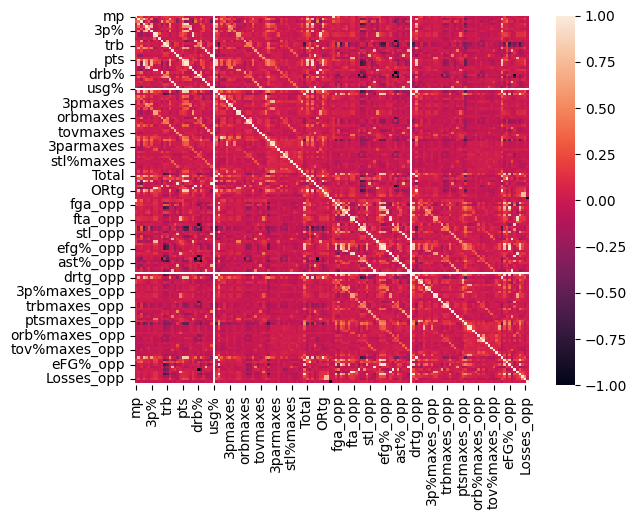

In [42]:
nba_2022_numerical = nba_2022.select_dtypes(include=['number'])
sns.heatmap(nba_2022_numerical.corr())

In [30]:
nba_2022_numerical.corr()['3p%'].sort_values(ascending=False)

3p%             1.000000
3p              0.771640
efg%            0.730040
eFG%            0.730040
ts%             0.704382
                  ...   
+/-maxes_opp   -0.370830
drb_opp        -0.388731
usg%                 NaN
usg%_opp             NaN
season               NaN
Name: 3p%, Length: 153, dtype: float64

#### Intuitive thought is that 3p%, efg%, and fg% should be related

## 2. Data Wrangling and Preprocessing for Modeling <a id='2'></a>

#### We can first identify certain columns that are not useful for modeling

In [97]:
nba_2022 = winrate(nba_2022)
nba_2022 = nba_2022.groupby("Teams", group_keys=False).apply(add_target)

# Filling missing value for 
nba_2022.loc[pd.isnull(nba_2022['target']), 'target'] = 2
nba_2022['target'] = nba_2022['target'].astype(int)

# We will try to use MinMax first and use StandardScaler for hyperparameters tuning
removed = ['target', 'date', 'Teams_opp', 'Teams','season','won', 'Wins', 'Losses', 'Wins_opp', 'Losses_opp']
valid_columns = nba_2022.columns[~nba_2022.columns.isin(removed)]

mm = MinMaxScaler()
nba_2022[valid_columns] = mm.fit_transform(nba_2022[valid_columns])

In [98]:
# Adding win rate of past 5 and 10 games
nba_2022 = rolling_no_merge(nba_2022)

nba_2022['home_next'] = add_col(nba_2022, 'home')
nba_2022['team_next_opp'] = add_col(nba_2022, 'Teams_opp')
nba_2022['date_next'] = add_col(nba_2022, 'date')

/var/folders/4m/qh070ww90rqgmcw604kkdt8r0000gn/T/ipykernel_38390/3371891778.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[new_col_name] = data.groupby(['Teams', 'season'])[valid_column].transform(lambda x: x.rolling(window, min_periods=1).mean())
/var/folders/4m/qh070ww90rqgmcw604kkdt8r0000gn/T/ipykernel_38390/3371891778.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[new_col_name] = data.groupby(['Teams', 'season'])[valid_column].transform(lambda x: x.rolling(window, min_periods=1).mean())
/var/folders/4m/

In [114]:
nba_2022_full = nba_2022.merge(nba_2022,
               left_on=['Teams', 'date_next'],
               right_on = ['team_next_opp', 'date_next'])
disregard = list(nba_2022_full.columns[nba_2022_full.dtypes == 'object'])
disregard = disregard + ["home_opp_5_x","target_x","target_y", "Wins_x", "Losses_x", "Wins_opp_x", "Losses_opp_x", "season_x" , "won_x" , "home_5_x" ,"home_10_x" ,"season_5_x", "season_10_x" , "Wins_y" , "Losses_y" , "Wins_opp_y" , "Losses_opp_y" , "season_y" , "won_y" ,"home_5_y", "home_10_y","season_5_y", "season_10_y","home_opp_5_y", "home_opp_10_y"]
regard = nba_2022_full.columns[~nba_2022_full.columns.isin(disregard)]

## 3. Modeling <a id='3'></a>

### 3.1 Random Forest Classifier with Ridge as Feature Selector <a id='3_1'></a>

In [118]:
rr = RidgeClassifier(alpha=1)
split = TimeSeriesSplit(n_splits=3)
sfs = SequentialFeatureSelector(rr, n_features_to_select = 50, direction='forward', cv=split)

sfs.fit(nba_2022_full[regard], nba_2022_full['target_x'])
predictors = list(regard[sfs.get_support()])
predictors

['stl_x',
 'trb%_x',
 'stl%_x',
 'usg%_x',
 'fgmaxes_x',
 '3pamaxes_x',
 'ft%maxes_x',
 'orb%maxes_x',
 'trb%maxes_x',
 'ft%_opp_x',
 'pf_opp_x',
 'ftr_opp_x',
 'trb%_opp_x',
 'usg%_opp_x',
 '3p%maxes_opp_x',
 'ftamaxes_opp_x',
 'ft%maxes_opp_x',
 'efg%maxes_opp_x',
 'ftrmaxes_opp_x',
 'orb%maxes_opp_x',
 'blk%maxes_opp_x',
 'usg%maxes_opp_x',
 'FT/FGA_opp_x',
 'winrate_x',
 'winrate_opp_x',
 'won_rolling_10_x',
 'mp_y',
 '3p%_y',
 'pf_y',
 'usg%_y',
 '+/-maxes_y',
 'efg%maxes_y',
 'trb%maxes_y',
 'mp_opp_y',
 'ft%_opp_y',
 'tov_opp_y',
 'pf_opp_y',
 'ftr_opp_y',
 'tov%_opp_y',
 'usg%_opp_y',
 'fg%maxes_opp_y',
 '3p%maxes_opp_y',
 'ftamaxes_opp_y',
 'ftrmaxes_opp_y',
 'usg%maxes_opp_y',
 'TOV%_opp_y',
 'FT/FGA_opp_y',
 'winrate_y',
 'winrate_opp_y',
 'won_rolling_10_y']

In [144]:
# Model path
path_rf_with_ridge = "/Users/liqingyang/Documents/GitHub/sports_trading/sports_betting/ml_notebooks/weights/random_forest_with_ridge.pkl"

random_forest = RandomForestClassifier(n_estimators=300)

X = nba_2022_full[predictors]
y = nba_2022_full['target_x']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

random_forest.fit(X_train, y_train)
predictions = random_forest.predict(X_test)
result = pd.Series(predictions, index = y_test.index)

final = pd.concat([y_test, result], axis=1)
final.columns = ['Actual', 'Predictions']

with open(path_rf_with_ridge, 'wb') as f:
    pickle.dump(random_forest, f)

accuracy = accuracy_score(final['Actual'], final['Predictions'])
f1 = f1_score(final['Actual'], final['Predictions'])

print("The accuracy is:", accuracy)
print("The F1 is:", f1)

The accuracy is: 0.6399176954732511
The F1 is: 0.6450304259634888


### Hyperparameters Tuning

In [ ]:
X = nba_2022_full[predictors]
y = nba_2022_full['target_x']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2, random_state=42)

# Define parameter grid 
param_grid = {
    'n_estimators': [50, 100, 200, 300],  
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 7, 10], 
    'min_samples_leaf': [1, 2, 4],  
    'max_features': [None, 'sqrt'],  
    'bootstrap': [True, False],  
    'min_weight_fraction_leaf': [0.0, 0.1],  
    'max_leaf_nodes': [None, 10, 20], 
    'min_impurity_decrease': [0.0, 0.1], 
    'class_weight': [None, 'balanced']  
}

# Initialize a DataFrame to store results
results_df = pd.DataFrame(columns=['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features', 'bootstrap', 'min_weight_fraction_leaf', 'max_leaf_nodes', 'min_impurity_decrease', 'class_weight', 'average_accuracy', 'f1_score'])

results_list = []

# Iterate over all combinations of parameters
for params in ParameterGrid(param_grid):
    scores = []  # to store scores of each fold      
    # Initialize and fit the model
    model = RandomForestClassifier(**params, random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions and calculate accuracy
    predictions = model.predict(X_test)
    score = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    avg_score = np.mean(scores)
    
    results_iteration = params.copy()  
    results_iteration['average_accuracy'] = avg_score
    results_iteration['f1_score'] = f1
    results_list.append(results_iteration)

# Convert the list of results to a DataFrame
results_df = pd.DataFrame(results_list)
path_rf_result = "/Users/liqingyang/Documents/GitHub/sports_trading/sports_betting/ml_notebooks/hyperparameter_tuning_result/random_forest_tune.csv"

results_df.to_csv(path_rf_result, index=False)

### 3.2 Logistic Regression with Lasso to Select Features <a id='3_2'></a>
- Currently using regular train test split

In [ ]:
# Instantiate LogisticRegression with lasso regression
lr_l1 = LogisticRegression(penalty='l1', solver='saga', max_iter=10000)
split = TimeSeriesSplit(n_splits=3)
sfs = SequentialFeatureSelector(lr_l1, n_features_to_select=50, direction='forward', cv=split)

sfs.fit(nba_2022_full[regard], nba_2022_full['target_x'])
predictors = list(regard[sfs.get_support()])
predictors

In [ ]:
# Model path
path_logistic_with_lasso = "/Users/liqingyang/Documents/GitHub/sports_trading/sports_betting/ml_notebooks/weights/logistic_with_lasso.pkl"

X = nba_2022_full[predictors]
y = nba_2022_full['target_x']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle= False, test_size=0.2)

lr_l1.fit(X_train, y_train)
predictions = lr_l1.predict(X_test)
result = pd.Series(predictions, index = y_test.index)

final = pd.concat([y_test, result], axis=1)
final.columns = ['Actual', 'Predictions']

with open(path_logistic_with_lasso, 'wb') as f:
    pickle.dump(lr_l1, f)

accuracy = accuracy_score(final['Actual'], final['Predictions'])
f1_score = f1_score(final['Actual'], final['Predictions'])